**Exploratory Data Analysis (EDA)**:
First, I performed an EDA to understand the structure, characteristics, and relationships within your data. This involved loading the data into a DataFrame, examining the statistical distribution of its features and target variables, and plotting various visualizations such as a distribution plot of the target variable and a feature importance plot using RandomForestRegressor.

**Data Splitting:** I split the data into a training set and a testing set, using two thirds of the data for training and one third for testing.

**Model Creation and Grid Search:** I then defined a function to create a Keras model. I used the KerasRegressor from SciKeras for the model I defined
I then set up a parameter grid for the hyperparameters we want to tune, and then performed a grid search over this parameter grid to  find the combination of hyperparameters that produces the best model.

**Model Evaluation:** After the grid search, I examined the best score achieved and the combination of hyperparameters that produced this score. I used the best estimator from the grid search to make predictions on the testing data and computed the mean squared error (MSE) for these predictions and the training data. I then plotted the predicted vs actual values for both training and testing data to visually assess model performance.

**Results Visualization:** After model training and evaluation, I plotted the residual errors and the actual vs predicted values to analyze the model performance visually.

###  Import Libraries

In [1]:
!pip install scikeras

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l1_l2
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
number_of_elements,1766.0,4.772933,0.739783,3.000000,4.000000,5.000000,5.000000,7.000000
mean_atomic_mass,1766.0,84.674092,11.966167,39.633467,75.887017,83.244760,92.266740,142.376700
wtd_mean_atomic_mass,1766.0,63.182558,16.085538,35.241077,51.532434,56.804884,68.358205,152.464120
gmean_atomic_mass,1766.0,64.253162,7.931626,22.005876,59.356672,63.188317,69.016082,98.761740
wtd_gmean_atomic_mass,1766.0,43.859830,15.603284,23.759674,35.059244,36.112303,38.976165,137.387467
...,...,...,...,...,...,...,...,...
range_Valence,1765.0,1.563739,0.881300,1.000000,1.000000,1.000000,2.000000,5.000000
wtd_range_Valence,1765.0,0.925414,0.190449,0.057143,0.833593,0.979118,1.056154,2.300000
std_Valence,1765.0,0.639086,0.319231,0.372678,0.433013,0.433013,0.800000,2.160247
wtd_std_Valence,1765.0,0.481049,0.309706,0.187942,0.269333,0.349927,0.498618,1.766414


In [5]:
# Check for missing values
df.isnull().sum()

number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
range_Valence            1
wtd_range_Valence        1
std_Valence              1
wtd_std_Valence          1
critical_temp            1
Length: 82, dtype: int64

In [6]:
# Remove missing values
df = df.dropna()

In [7]:
df.isnull().sum()

number_of_elements       0
mean_atomic_mass         0
wtd_mean_atomic_mass     0
gmean_atomic_mass        0
wtd_gmean_atomic_mass    0
                        ..
range_Valence            0
wtd_range_Valence        0
std_Valence              0
wtd_std_Valence          0
critical_temp            0
Length: 82, dtype: int64

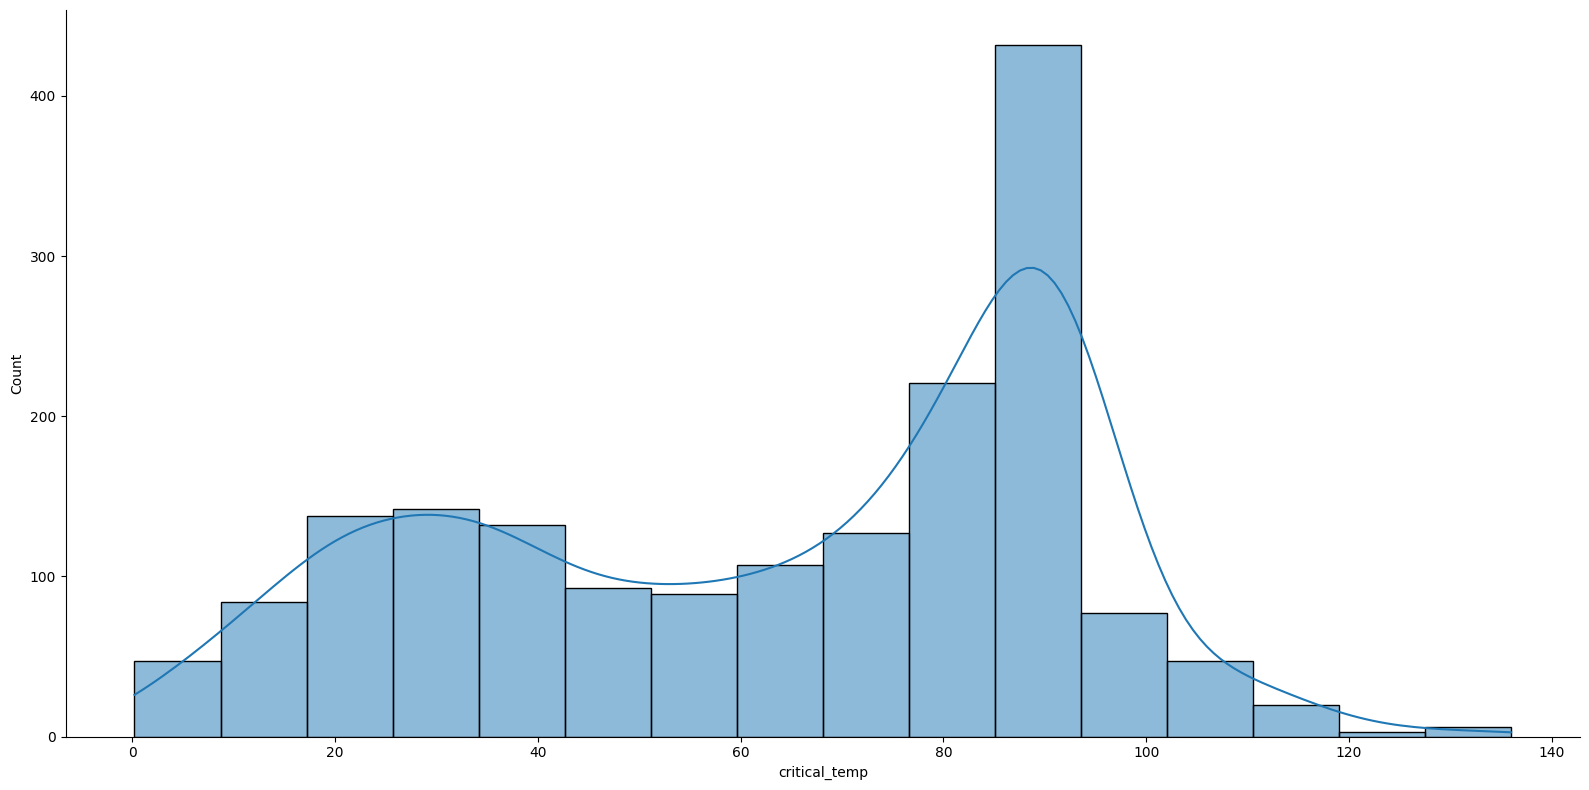

In [8]:
sns.displot(df['critical_temp'], kde=True, height=8, aspect=2)
plt.show()

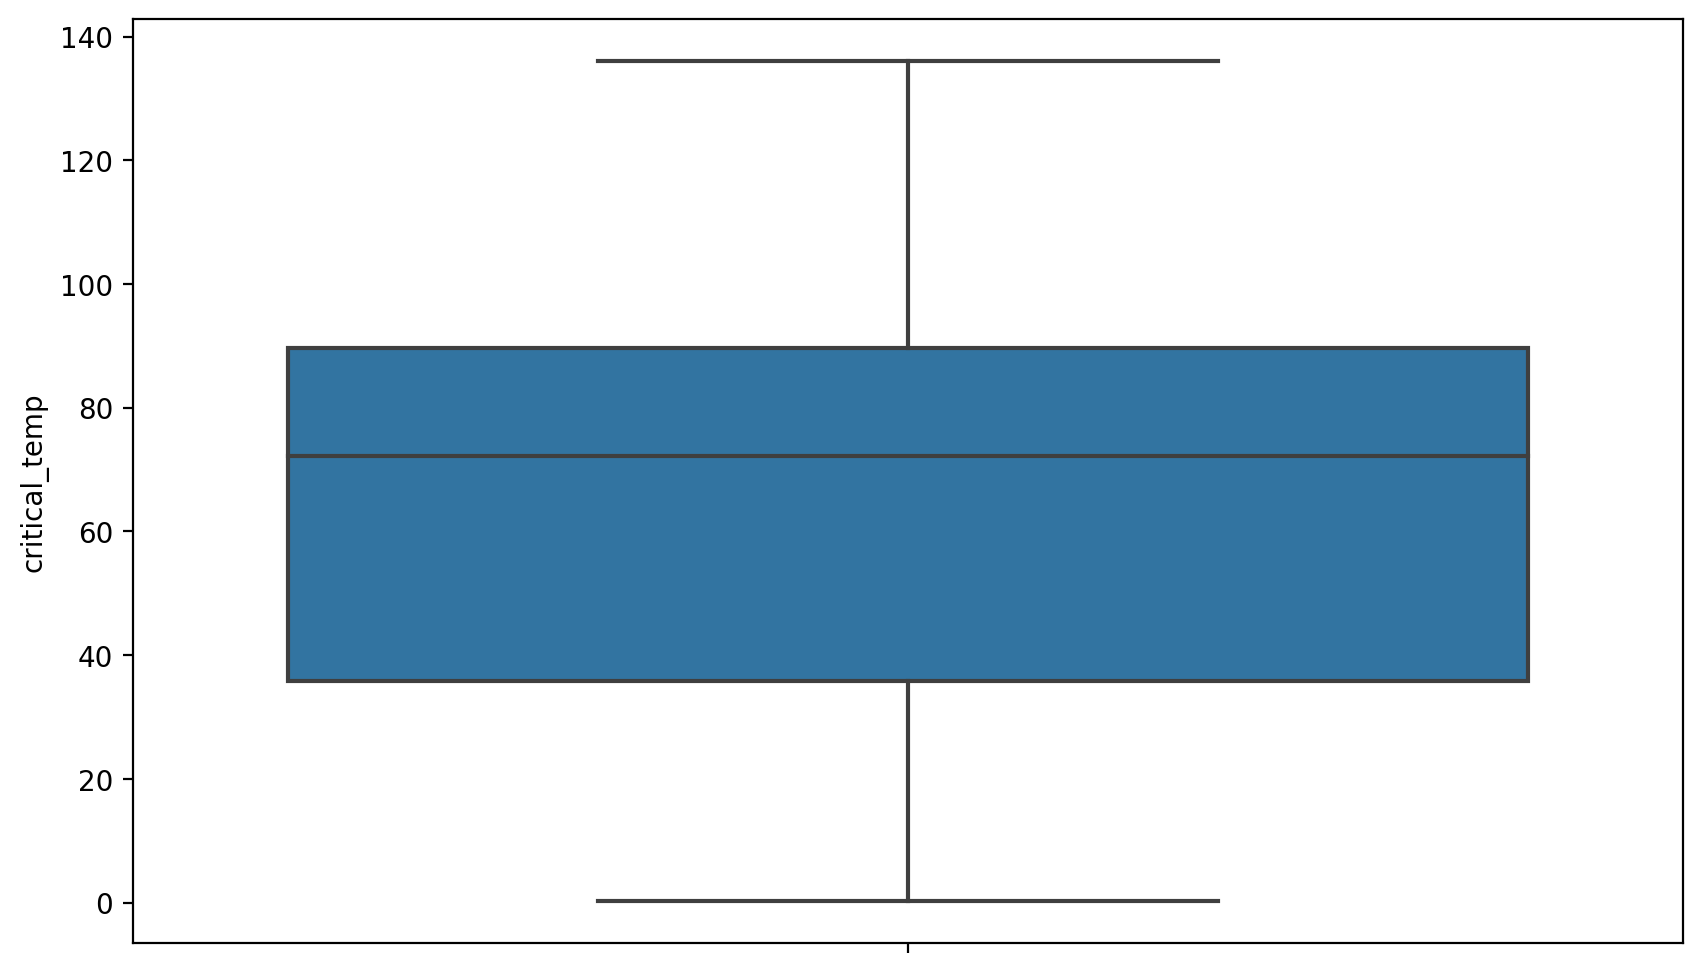

In [9]:
plt.figure(figsize=(10,6),dpi=200)
sns.boxplot(y=df['critical_temp'])
plt.show()

### Use random forest regressor to find out which features are the most important

In [10]:
X = df.drop('critical_temp', axis=1)
y = df['critical_temp']

model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, df.columns[:-1])

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

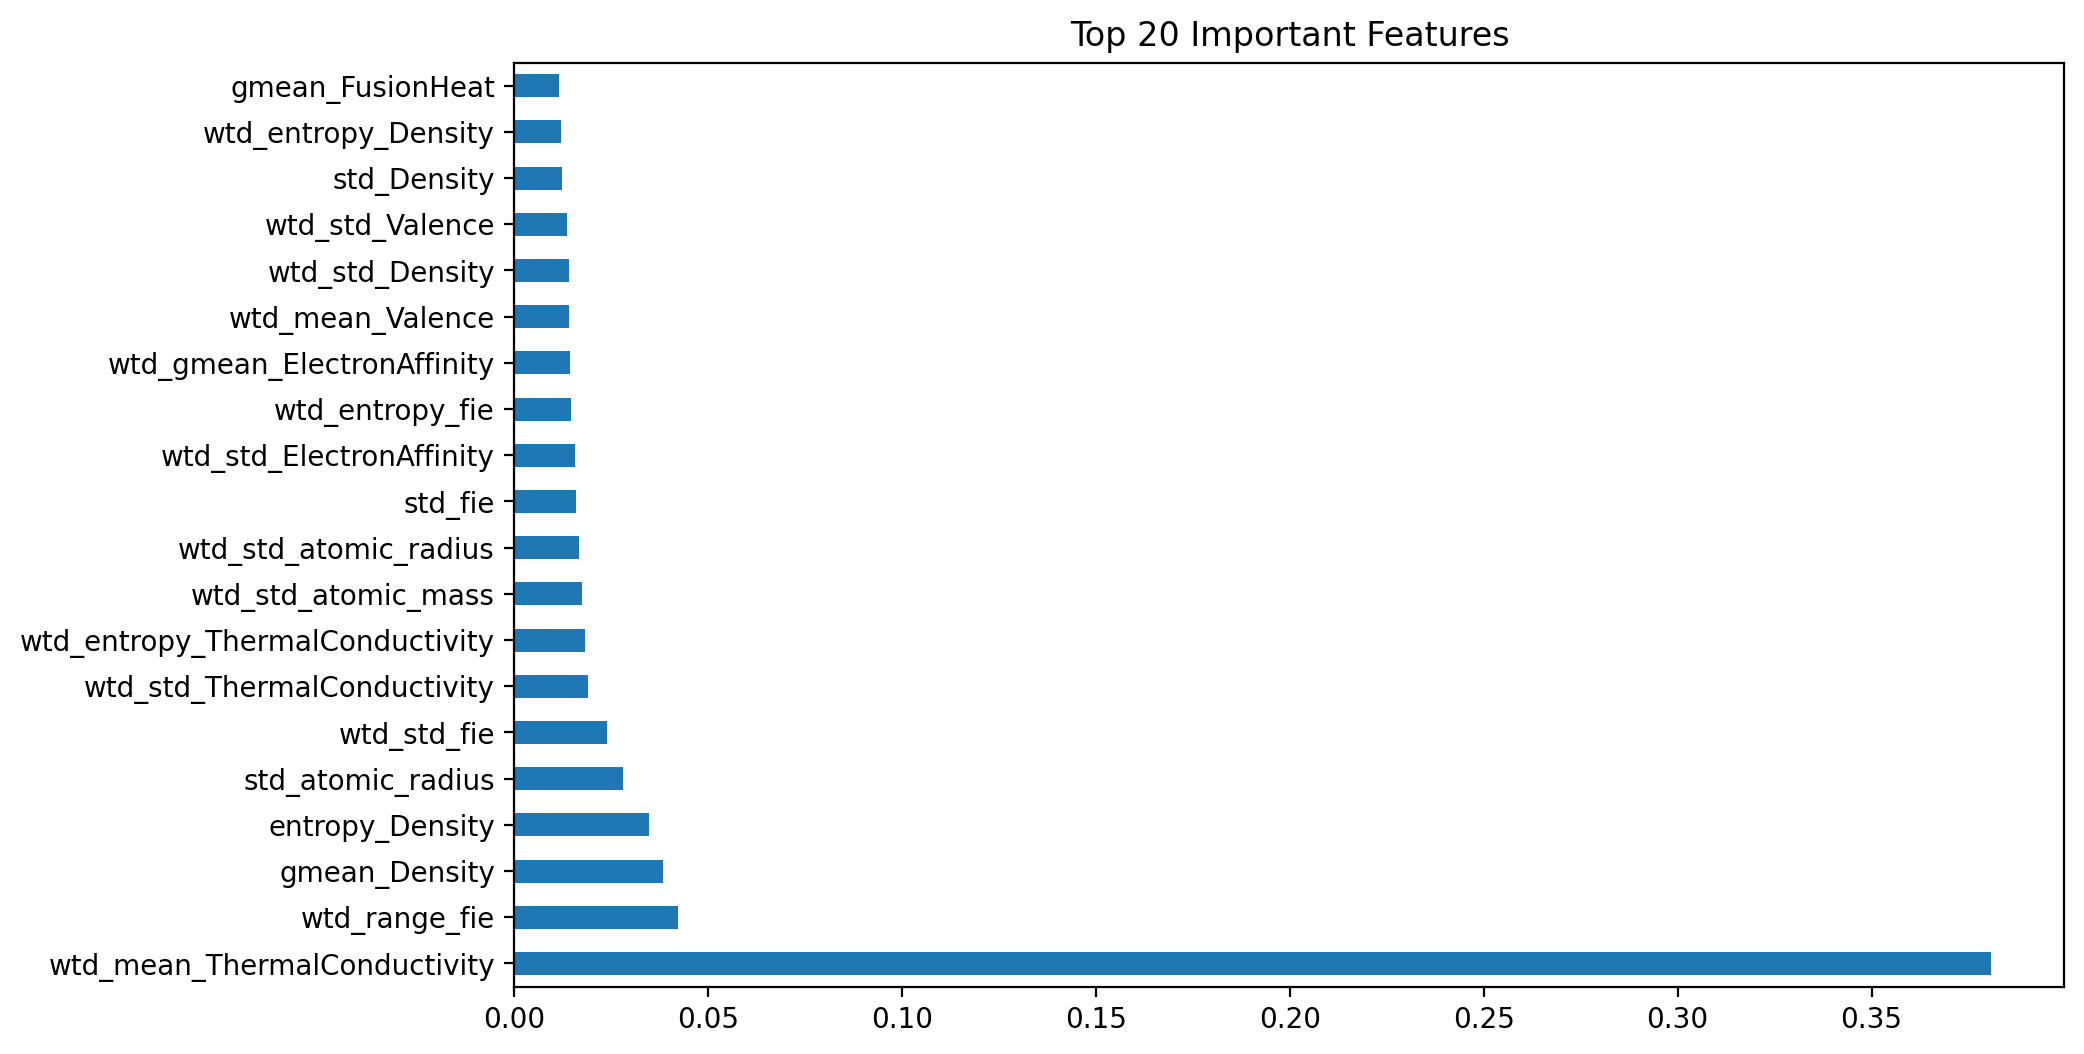

In [11]:
# Plot the top 20 most important features
plt.figure(figsize=(10,6), dpi=200)
f_importances.sort_values(ascending=False)[:20].plot(kind='barh')
plt.title('Top 20 Important Features')
plt.show()


### Split the data into training and test sets and standardize the features

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Define the Keras Model

In [14]:
def create_model(n_hidden_layers=1, n_neurons=1, l1=0.0, l2=0.0, learning_rate=0.01):
    model = Sequential()
    model.add(Dense(n_neurons, input_dim=X.shape[1], activation='relu', kernel_regularizer=l1_l2(l1, l2)))
    for _ in range(n_hidden_layers):
        model.add(Dense(n_neurons, activation='relu', kernel_regularizer=l1_l2(l1, l2)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    return model


In [15]:
# Set up parameters grid
param_grid = {
    'n_hidden_layers': [4, 6],
    'n_neurons': [32, 64],
    'l1': [0.01, 0.001],
    'l2': [0.01, 0.001],
    'learning_rate': [0.1, 0.01, 0.001]
}

In [18]:
model = KerasRegressor(model=create_model, epochs=100, batch_size=64, verbose=0,
                       l1=0.01, l2=0.01, learning_rate=0.1, n_hidden_layers=1, n_neurons=32)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

In [19]:
# Train the model
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [20]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.718542 using {'l1': 0.001, 'l2': 0.001, 'learning_rate': 0.01, 'n_hidden_layers': 4, 'n_neurons': 64}


### Evaluation on test set

In [25]:
# Prediction and evaluation
y_train_pred = grid_result.predict(X_train)
y_test_pred = grid_result.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

In [26]:
print('Training MSE:', train_mse)
print('Test MSE:', test_mse)

Training MSE: 115.88373916744007
Test MSE: 188.41609113800376


### Prediction Error plot
You can see it the residuals are scattered around the horizontal axis

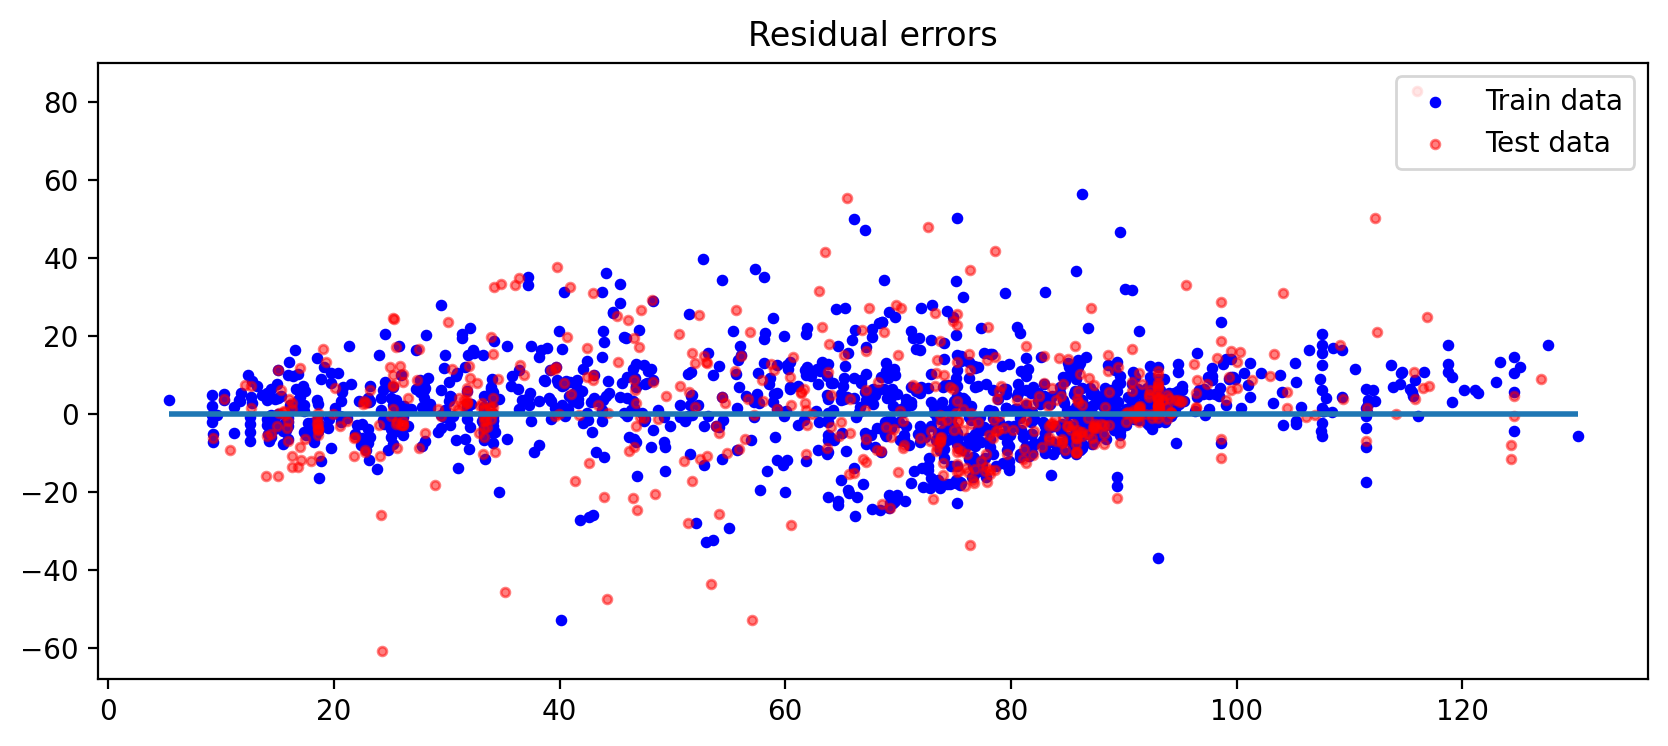

In [39]:
plt.figure(figsize=(10,4),dpi=200)
plt.scatter(y_train_pred, y_train_pred - y_train, color = "blue", s = 10, label = 'Train data')
plt.scatter(y_test_pred, y_test_pred - y_test, color = "red", s = 10, label = 'Test data', alpha=0.5)
plt.hlines(y = 0, xmin = min(np.min(y_train_pred), np.min(y_test_pred)), xmax = max(np.max(y_train_pred), np.max(y_test_pred)), linewidth = 2)
plt.legend(loc = 'upper right')
plt.title("Residual errors")
plt.show()


### Scatterplot showing Actual vs Predicted values
You can see that it is fairly accurate

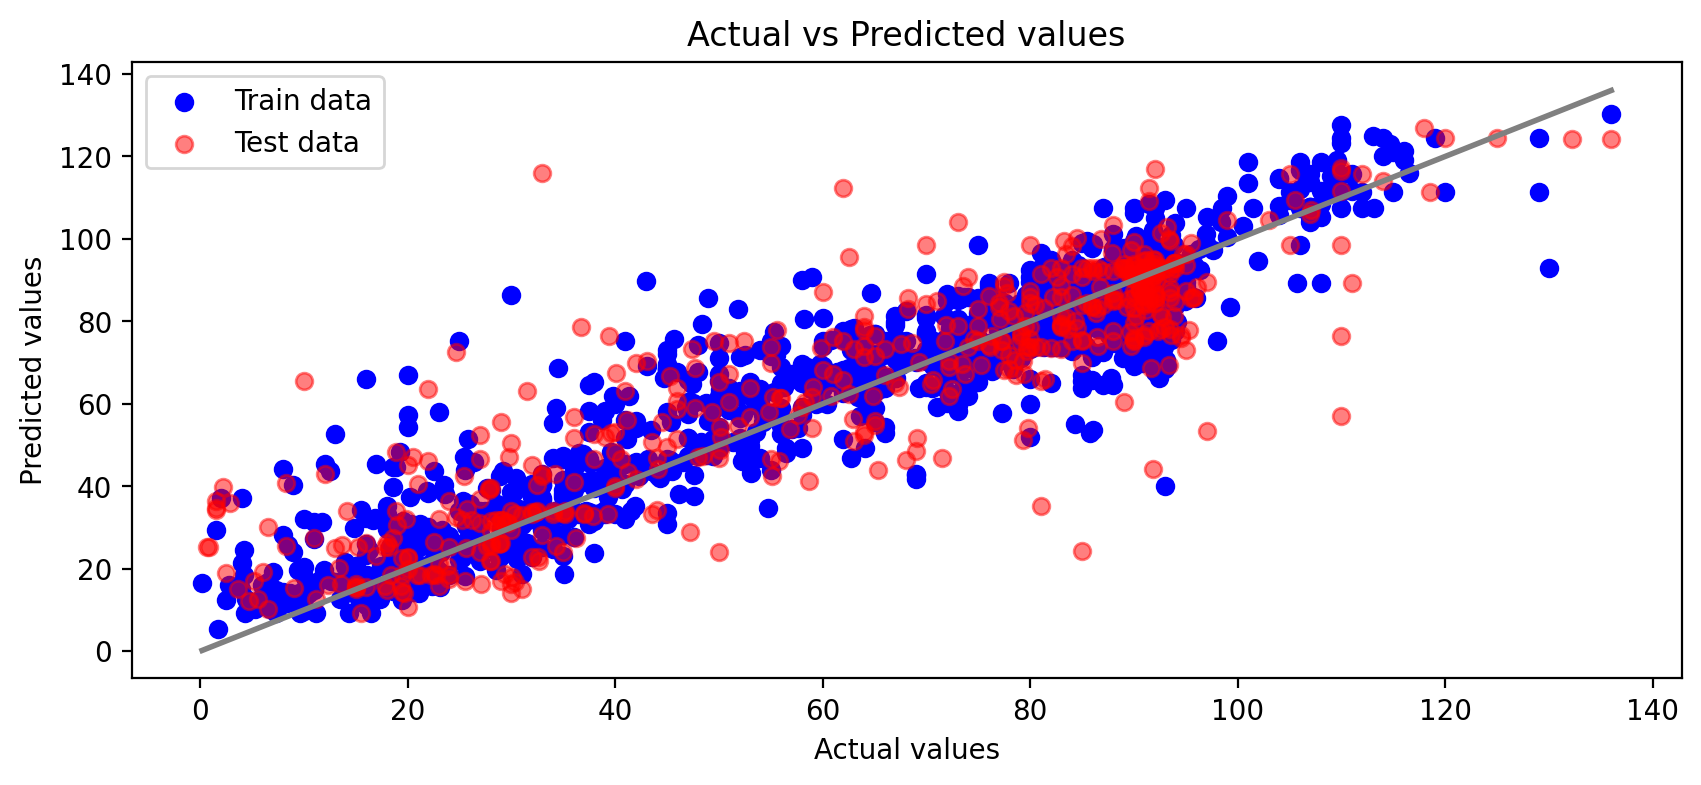

In [38]:
plt.figure(figsize=(10,4),dpi=200)
plt.scatter(y_train, y_train_pred, color = "blue", label = 'Train data')
plt.scatter(y_test, y_test_pred, color = "red", label = 'Test data',alpha=0.5)
plt.legend(loc = 'upper left')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='gray', linewidth=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title("Actual vs Predicted values")
plt.show()